# Título Placeholder

## Preparar ambiente

In [25]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## Dados do Sistema e Constantes

In [26]:
# Tempo em minutos, de acordo com seção 3.3.2. (FABRICAÇÃO DO PRODUTO)
t_total = 60
# Massa de água e mosto, em kg, baseado na seção 3.3.2. (FABRICAÇÃO DO PRODUTO)
massa_agua = 25.5
massa_malte = 8.5
massa_mosto = massa_agua + massa_malte
# Uma saca de malte de 25 kg tem aproximadamente 40 litros ocupados, uma proporção de 5/8, para 8,5 kg de malte, temos então 13.6 litros
volume_malte = 13.6
volume_mosto = massa_agua + volume_malte
# Aproximado da capacidade térmica da água em KJ/(kg·K), baseado em https://www.fq.pt/tabelas/capacidades-termicas-massicas . O mosto é uma mistura, eu estou usando o calor específico da água como aproximação.
c = 4.1855

# Os dados relacinados à equação de Arrhenius forão testados entre 363.15 e 403.15 k (90 C° e 130 C°)
# 293.15 k é equivalente a 20 C°, eu achei que seria um valor inicial adequado
limites_temperatura = [(293.15, 403.15)]
T_min, T_max = limites_temperatura[0]
T0 = 293.15

# Potêcia da fonte de calor em kw, de acordo com (3.3.1) ESTRUTURA DA PLANTA PILOTO)
potencia = 6

# UNUSED:
# Constantes da equação de Antoine para a água de acordo com http://paginapessoal.utfpr.edu.br/lisandra/fisico-quimica-alimentos/anexos/C8-6_-_Pv_Antoine.pdf/view
#ant_A = 18.3036
#ant_B = 3816.44
#ant_C = -46.13
# A constante universal dos gases perfeitos, valor em J mol^-1 K^-1, de acordo com https://physics.nist.gov/cgi-bin/cuu/Value?r , CODATA
#R = 8.31446261
# Limites baseados nas restrições para a aplicação da Lei de Atoine de acordo com http://paginapessoal.utfpr.edu.br/lisandra/fisico-quimica-alimentos/anexos/C8-6_-_Pv_Antoine.pdf/view
# 284 e 441 Em Kelvin
# Massa molar da água de acordo com https://webbook.nist.gov/cgi/cbook.cgi?ID=C7732185&Mask=200
# Por enquanto, estou usando a massa molar da água, por que o mosto é uma mistura e, nesse caso, é composto, em grande parte, feito de água, mas eu posso levar em conta outras substências, como açúcar
#massa_molar = 18.0153

# Funções Físico-Químicas

In [27]:
def isomerizacao(T):
    # "Velocidade da isomerização"
    # A constante de Arrhenius para esse caso seria k = (7.9 × 10^11) e^(-11858/T), on T é a Temperatura Absoluta, baseado em https://doi.org/10.1021/jf0481296
    return 7.9e11 * np.exp(-11858 / T)

def calcular_iso_total(T, time_step):
    # Só considerando temperaturas dentro dos limites dos daods no artigo https://doi.org/10.1021/jf0481296
    T_min_iso, T_max_iso = 363.15, 403.15

    idx_validos = (T >= T_min_iso) & (T <= T_max_iso)
    T_iso = T[idx_validos]

    if len(T_iso) == 0:
        return 0

    taxas = isomerizacao(T_iso)
    return np.sum(taxas * time_step)

def calcular_energia_fornecida():
    # TODO: Pesquisar eficiência térmica de uma resistência elétrica submersa, por enquanto eu estou assumindo eficiência completa
    # formula baseado em https://phys.libretexts.org/Bookshelves/University_Physics/University_Physics_(OpenStax)/University_Physics_II_-_Thermodynamics_Electricity_and_Magnetism_(OpenStax)/09%3A_Current_and_Resistance/9.06%3A_Electrical_Energy_and_Power
    return potencia * t_total * 60

def calcular_energia_usada(delta_T):
    return float(np.sum(c * massa_mosto * delta_T))

def calcular_massa_evaporada(delta_T):
    energia_fornecida = calcular_energia_fornecida()
    energia_usada = calcular_energia_usada(delta_T)
    energia_restante = energia_fornecida - energia_usada
    # TODO: implementar uma fórmula para entalpia específica de vaporização da água baseada em cada resgistro de temperatura
    # a entalpia específica de vaporização da água varia com a temperatura, por enquanto eu estou o usando o valor para água a 100 C°, em kj/kg. Baseado em https://en.wikipedia.org/wiki/Enthalpy_of_vaporization
    h = 2257
    return energia_restante/h

def calcular_energia_termica_total(T, T0, massa, capacidade_termica, T_min, T_max):
    # As diferenças entre as temperaturas do vetor
    delta_T = np.diff(T)
    return np.sum(delta_T * massa * capacidade_termica), delta_T

def calcular_densidade(massa_evaporada):
    massa_restante = massa_mosto - massa_evaporada
    volume_restante = volume_mosto - massa_evaporada
    return massa_restante/volume_restante

def calcular_penalizacao_densidade(densidade, faixa=(1000, 1025)):
    # faixa baseada nesse documento da universidade de toronto https://www.physics.utoronto.ca/~poppitz/poppitz/PHY1530_files/BeerPhysics.pdf
    min_d, max_d = faixa
    if min_d <= densidade <= max_d:
        return 0
    else:
        desvio = min(abs(densidade - min_d), abs(densidade - max_d))
        return desvio / ((min_d + max_d) / 2)

# UNUSED:
#def pressao_vapor(T):
#    T_celsius = T - 273.15
#    # P, o valor sendo retornado, fica em mmHg
#    return 10 ** (ant_A - ant_B / (ant_C + T_celsius))

#def quantidade_materia():
#    # formula baseada em https://chem.libretexts.org/Bookshelves/Introductory_Chemistry/Chemistry_for_Changing_Times_(Hill_and_McCreary)/05%3A_Chemical_Accounting/5.04%3A_Molar_Mass-_Mole-to-Mass_and_Mass-to-Mole_Conversions
#    # usando massa da água por enquanto, já que eu estou usando a massa molar da água
#    return massa_agua/massa_molar

#def densidade_vapor(P,T):
#    n = quantidade_materia()
#    volume = (n*R*T)/P

# Função Objetivo

A entrada de temperatura (ou seja, os valores de T) precisa ter espaços de tempo equivalentes.

In [28]:

def func_objetivo(T):

    T = np.clip(T, T_min, T_max)
    time_step = 60 / len(T)
    
    energia_total, delta_T = calcular_energia_termica_total(T, T0, massa_mosto, c, T_min, T_max)
    
    massa_evaporada = calcular_massa_evaporada(delta_T)

    iso_total = calcular_iso_total(T, time_step)

    densidade = calcular_densidade(massa_evaporada)

    energia_norm = energia_total / 10000
    iso_norm = iso_total / 1.0
    evap_norm = massa_evaporada / massa_mosto
    penalizacao_densidade = calcular_penalizacao_densidade(densidade)


    # Pesos, de acordo com o objetivo (Minimizar energia e evaporação, maximizar isomerização e regular a densidade), seção 3.3.3.(CONTROLE ÓTIMO MULTIOBJETIVO UTILIZANDO ALGORITMO GENÉTICO)
    w1, w2, w3, w4 = -1, -1, 1, 1

    return (
    w1 * energia_norm +
    w3 * evap_norm +
    w4 * penalizacao_densidade +
    w2 * iso_norm
    )


In [ ]:
T_init = np.linspace(T_min, T_max, t_total)
res = minimize(func_objetivo, T_init, bounds=[(T_min, T_max)] * t_total, method='L-BFGS-B')
T_otimo = res.x
time_step = 60 / len(T_otimo)
energia_total, delta_T = calcular_energia_termica_total(T_otimo, T0, massa_mosto, c, T_min, T_max)
massa_evaporada = calcular_massa_evaporada(delta_T)
iso_total = calcular_iso_total(T_otimo, time_step)
densidade = calcular_densidade(massa_evaporada)

print("Sucesso:", res.success)
print("Mensagem:", res.message)
print("Energia total:", energia_total)
print("Massa evaporada:", massa_evaporada)
print("Isomerização total:", iso_total)
print("Densidade final:", densidade)
print("Temperaturas ótimas:", res.x)


Sucesso: True
Mensagem: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
Temperaturas ótimas: [293.15       295.01441763 296.87889484 298.74323119 300.60767627
 302.4720276  304.33644068 306.20084748 308.06535146 309.92967187
 311.79414907 313.65848543 315.52293051 317.38728184 319.25169492
 321.11610172 322.9806057  324.84492611 326.70940331 328.57373967
 330.43818474 332.30253608 334.16694915 336.03135595 337.89585994
 339.76018035 341.62465755 343.48899391 345.35343898 347.21779032
 349.08220339 350.94661019 352.81121029 354.67543458 356.53991179
 358.40424814 360.26869322 362.13305087 403.15       403.15
 403.15       403.15       403.15       403.15       403.15
 403.15       403.15       403.15       403.15       403.15
 403.15       403.15       403.15       403.15       403.15
 403.15       403.15       403.15       403.15       403.15      ]
Energia total: 15653.77
Massa evaporada: 2.6345724412937526
Isomerização total: 2.9240554991347723
Densidade final: 0.8601415000060144


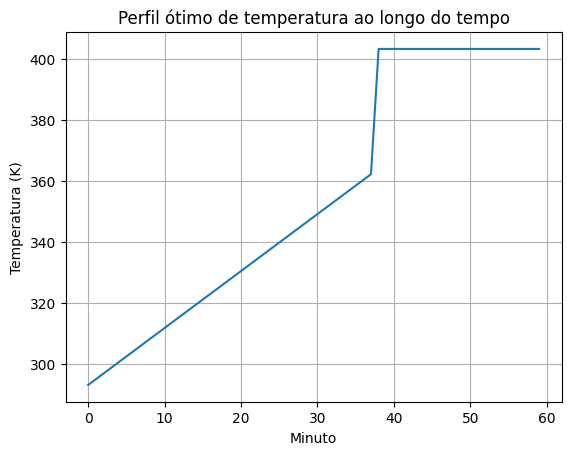

In [30]:
plt.plot(res.x)
plt.title("Perfil ótimo de temperatura ao longo do tempo")
plt.xlabel("Minuto")
plt.ylabel("Temperatura (K)")
plt.grid(True)
plt.show()